In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import palettable as pltt
import seaborn as sns
from seaborn import palplot
import pandas as pd
from pysal.lib import weights
import numpy as np

from sklearn import cluster
from sklearn.cluster import KMeans

### Data Loading

In [2]:
# Data file paths
nfhs_dta_path = 'data/Indicators/ddl_nfhs_2011.dta'

# Read dta file in
nfhs_df = pd.read_stata(nfhs_dta_path)

# Display top of table
nfhs_df.head()

,pc11_district_id,pc11_district_name,pc11_state_id,pc11_state_name,richest,poorest,water_dwelling,water_fetch_women,hand_wash_water,hand_wash_soap,no_toilet,firewood,num_rooms,mem_per_room,dum_65p,ex_diab_broad_ind_fem,ex_htn_broad_ind_fem,bmigrt27_5_fem,csmoke_fem
0,001,Kupwara,1,Jammu & Kashmir,8.311805,8.311969,7.057642,94.276848,96.740593,79.543213,0.826517,50.830387,2.346276,2.950212,34.456902,6.149359,20.011179,8.750773,2.286568
1,002,Badgam,1,Jammu & Kashmir,13.833916,1.934850,5.946562,93.986191,97.964149,89.273155,0.509206,36.995975,2.627664,2.467012,34.934296,8.610390,16.215515,15.766848,5.841035
2,003,LehLadakh,1,Jammu & Kashmir,6.757979,3.378412,6.472993,82.190422,76.990524,61.748947,1.690710,9.061338,2.088325,2.106857,29.558363,3.777166,9.615542,8.448392,0.089099
3,004,Kargil,1,Jammu & Kashmir,3.752654,18.584255,2.996613,87.871864,50.327682,41.393616,0.834409,36.651791,2.346389,2.533801,26.990757,0.854169,12.237219,4.230742,0.381606
4,005,Punch,1,Jammu & Kashmir,16.886778,11.014970,2.295900,94.575592,77.891991,58.317440,38.312347,77.006042,2.319419,2.831645,22.103603,7.220634,20.580841,10.000585,0.782809


### Data Documentation

The fourth round of the National Family Health Survey (NFHS-IV) was conducted in 2015-2016 across the country and collected detailed information on, among other things, wealth, access to water, sanitation, anthropometry, and biomarker-based data on hypertension, diabetes, and anemia. The NFHS-IV includes the perturbed location of each primary sampling unit, wherein all cases, perturbations are restricted such that the primary sampling unit lies within the original district.

Since men were interviewed in only 15% of the sample, data from men’s interview module are representative at the state level, but not at the district level. Therefore, we present district-level estimates of various risk factors only for women’s sample (ever-married women of age 15-49 years). State-level averages for men and women are significantly and positively correlated.  Categorizing districts using the prevalence of risk factors among women will arguably give the same results. 


|   Variable Name                   |             Definition                                      |
|-----------------------------------|-------------------------------------------------------------|
|pc11_district_id                   |Unique District ID Census 2011                               |
|pc11_district_name                 |District name in census 2011                                 |
|pc11_state_id                      |State ID in census 2011                                      |
|pc11_state_name                    |State name in census 2011                                    |
|richest                            |Richest 20% in 2016                                          |
|poorest                            |Poorest 20% in 2016                                          |
|water_dwelling                     |% housedholds with water access within dwelling in 2016      |
|water_fetch_women                  |% households where women fetch water from outside in 2016    | 
|hand_wash_water                    |% households with hand washing arrangement in 2016           |
|hand_wash_soap                     |% households handwashing with soap in 2016                   |
|no_toilet                          |% households who practiced open defecation in 2016           |
|firewood                           |% households who used firewood for fuel in 2016              |
|num_rooms                          |Average number of rooms in 2016                              |
|mem_per_room                       |Average number of members per room                           |
|dum_65p                            |% households with a 65+ member                               |
|ex_diab_broad_ind_fem              |% with Diabetes in 2016, Female                              |
|ex_htn_broad_ind_fem               |% with Hypertension in 2016, Female                          |
|bmigrt27_5_fem                     |% Obese in 2016, Female                                      |
|csmoke_fem                         |% consumed tobacco in 2016, Female                           |

### EDA

In [3]:
# General info
nfhs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 0 to 639
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pc11_district_id       640 non-null    object 
 1   pc11_district_name     640 non-null    object 
 2   pc11_state_id          640 non-null    int8   
 3   pc11_state_name        640 non-null    object 
 4   richest                640 non-null    float32
 5   poorest                640 non-null    float32
 6   water_dwelling         640 non-null    float32
 7   water_fetch_women      639 non-null    float32
 8   hand_wash_water        640 non-null    float32
 9   hand_wash_soap         640 non-null    float32
 10  no_toilet              640 non-null    float32
 11  firewood               640 non-null    float32
 12  num_rooms              640 non-null    float32
 13  mem_per_room           640 non-null    float32
 14  dum_65p                640 non-null    float32
 15  ex_dia

In [4]:
nfhs_df.describe()

,pc11_state_id,richest,poorest,water_dwelling,water_fetch_women,hand_wash_water,hand_wash_soap,no_toilet,firewood,num_rooms,mem_per_room,dum_65p,ex_diab_broad_ind_fem,ex_htn_broad_ind_fem,bmigrt27_5_fem,csmoke_fem
count,640.000000,640.000000,640.000000,640.000000,639.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000
mean,17.114062,17.473782,21.908625,16.211864,81.637047,81.672646,60.249737,38.590317,48.652565,1.879623,2.918630,26.820068,7.230788,16.721447,9.483605,0.951784
std,9.426486,16.851912,20.262398,16.476685,14.014462,14.091939,19.584084,27.735590,24.506046,0.315384,0.548551,6.711669,2.766906,6.976046,5.675599,1.876073
min,1.000000,0.212169,0.000000,0.000000,19.080664,26.605368,15.676787,0.000000,0.384373,1.257584,1.602532,4.699063,0.854169,5.695067,0.614388,0.000000
25%,9.000000,5.419747,4.755114,4.589918,76.340874,75.667856,45.427429,10.903347,29.559841,1.645206,2.570395,22.363012,5.200823,11.746585,5.074527,0.085854
50%,18.000000,11.891964,16.028654,9.617316,85.283455,85.244091,61.891230,39.332701,49.751259,1.842444,2.902598,26.725307,6.923182,15.516095,8.046713,0.342655
75%,24.000000,22.610771,36.102300,22.014040,91.427887,92.124743,75.006205,63.153172,69.175489,2.091085,3.320590,30.817529,8.806520,20.156674,12.982563,0.992104
max,35.000000,78.458748,77.227440,75.406708,100.000000,99.093544,98.663757,89.930992,95.187302,3.476580,4.395514,51.345753,20.016603,64.137093,31.977638,17.018433


In [5]:
variables = ['richest', 'poorest',  'water_dwelling', 'water_fetch_women', 'hand_wash_water',
             'hand_wash_soap', 'firewood', 'no_toilet', 'num_rooms','mem_per_room',
             'dum_65p', 'ex_diab_broad_ind_fem', 'ex_htn_broad_ind_fem', 'bmigrt27_5_fem', 'csmoke_fem']

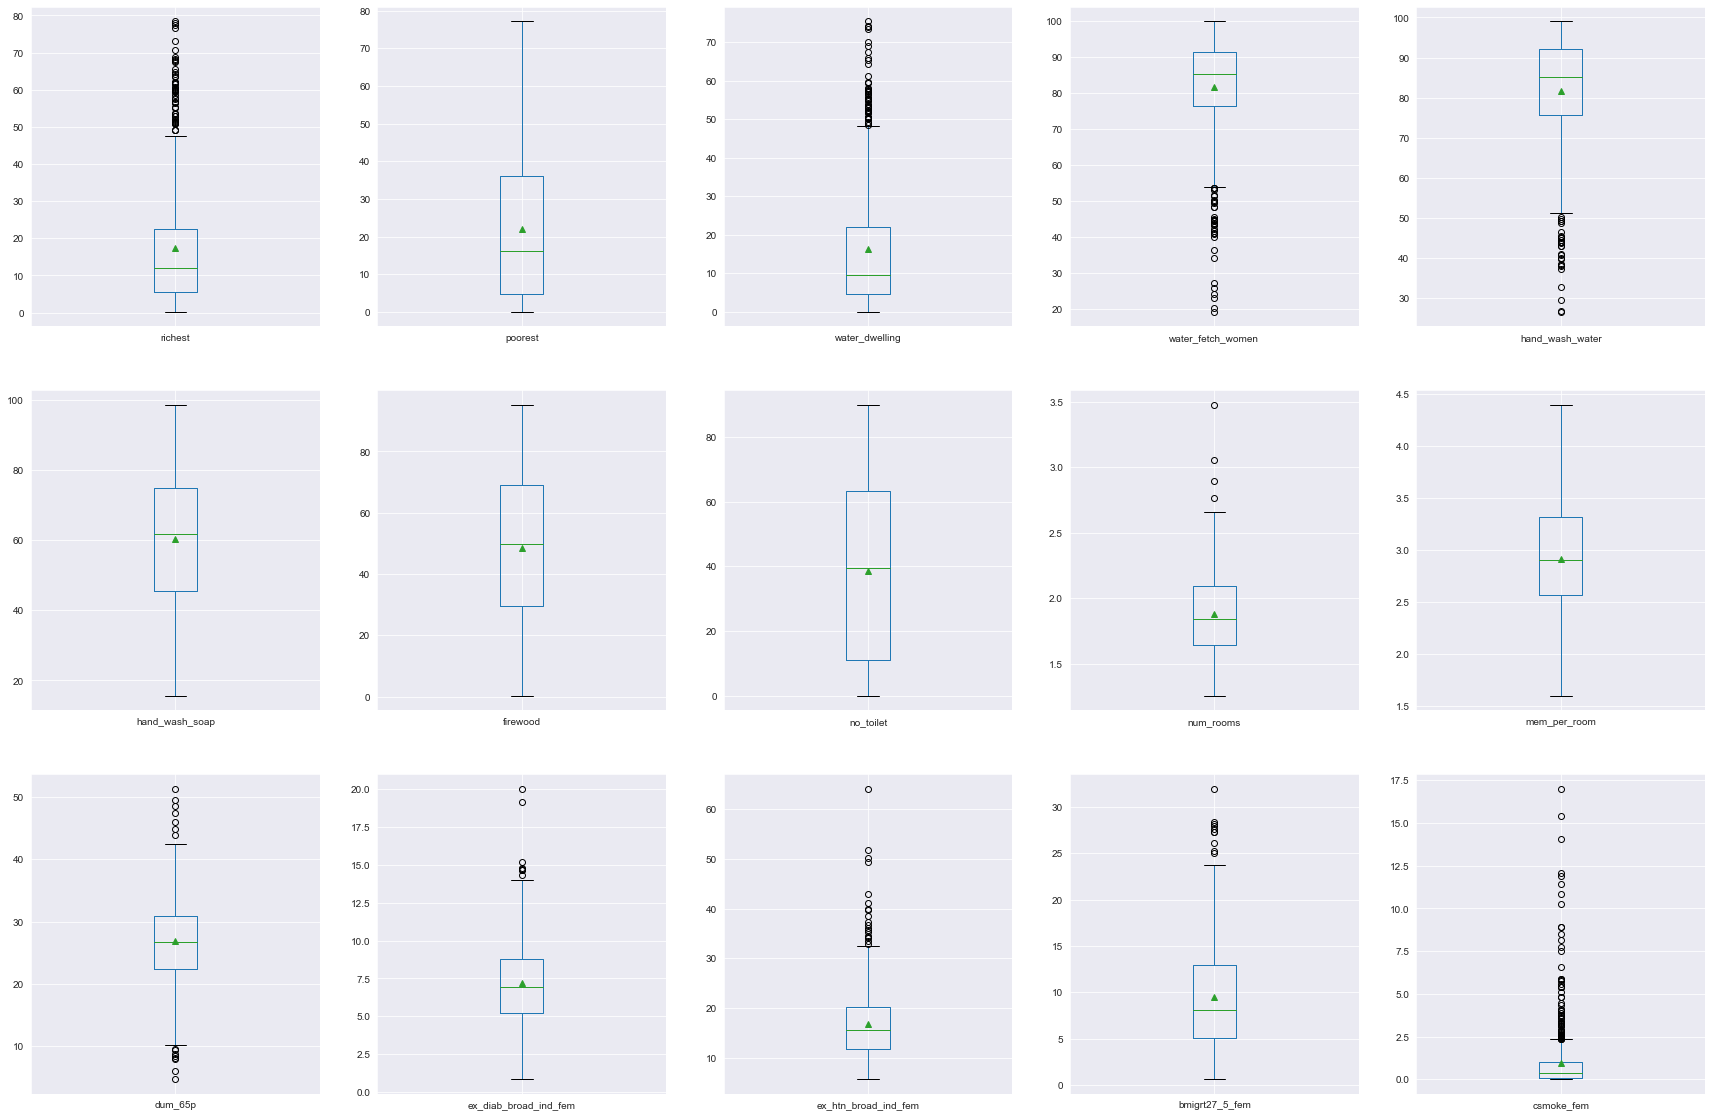

In [6]:
# Figure style
sns.set_style("dark")
# Create figure and axes (this time it's 15, arranged 5 by 3)
f, axs = plt.subplots(nrows=3, ncols=5, figsize=(30, 20))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    nfhs_df.boxplot(column=col, showmeans=True, ax=ax)
# Display the figure
plt.show()

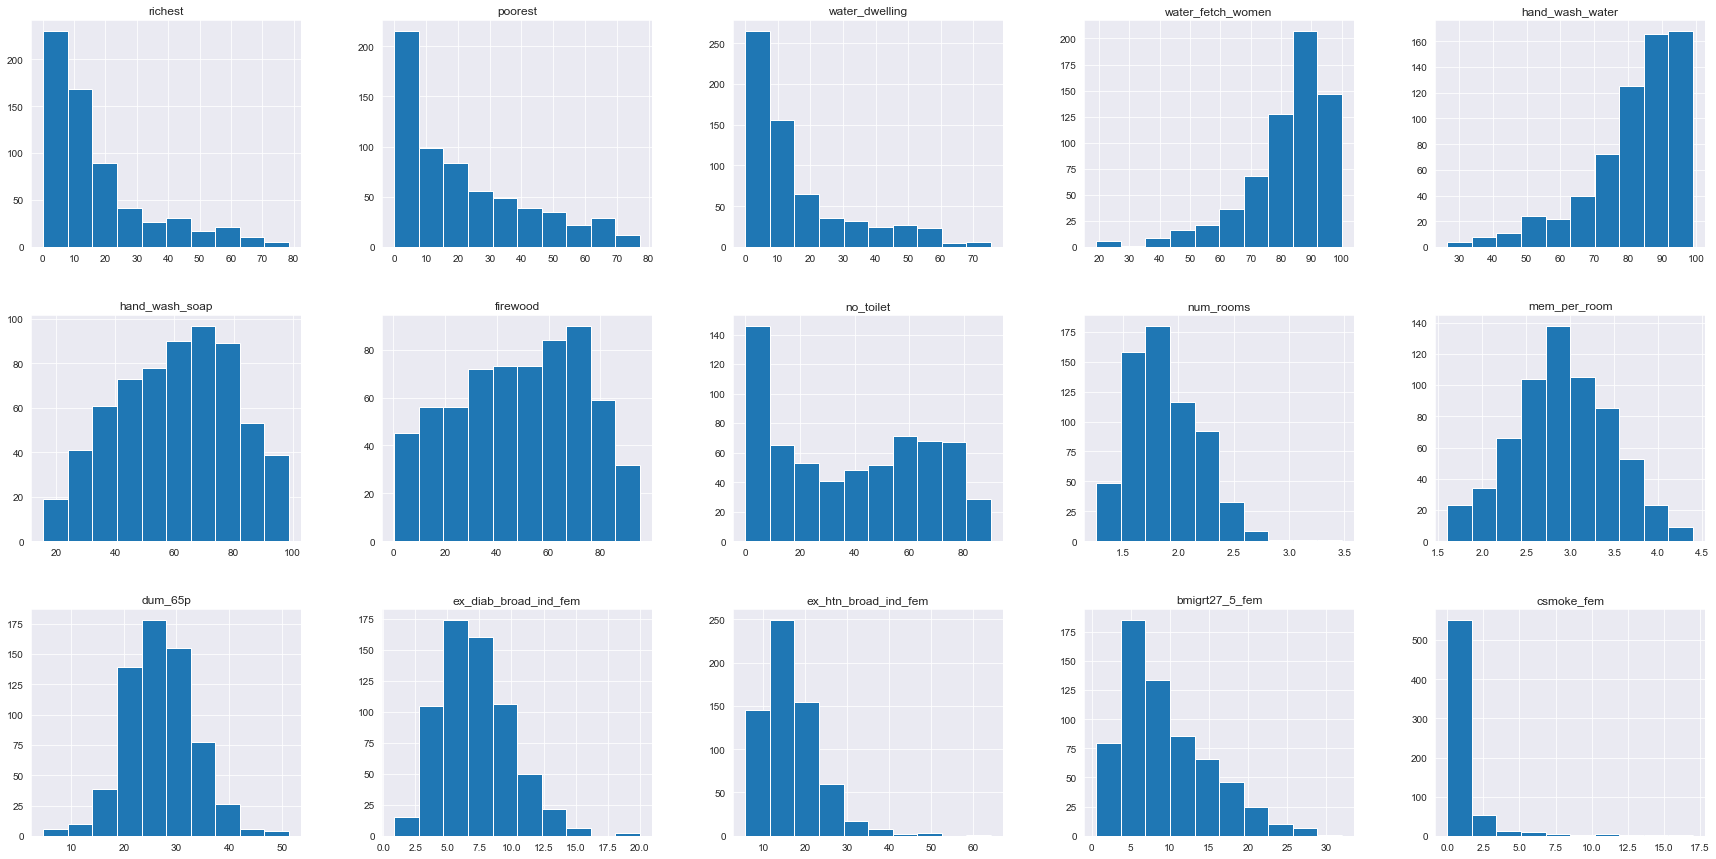

In [7]:
# Figure style
sns.set_style("darkgrid")
# Create figure and axes (this time it's 15, arranged 5 by 3)
f, axs = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    nfhs_df.hist(column=col, ax=ax)
     # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

### Transforming the Data
- Droping the name and count columns
- Fill NaN valur in 'water_fetch_women'
- Changing the type of the 'pc11_district_id' (couldn't be merged as object)
- Setting the index column

In [8]:
# Dropping columns with variables connected only with the women and district and state names
nfhs_df=nfhs_df.drop(['pc11_district_name', 'pc11_state_name', 'richest', 'poorest', 'num_rooms', ], axis=1
                    )

# Fill NaN value with 0
nfhs_df['water_fetch_women'] = nfhs_df['water_fetch_women' ].fillna(0.0)

# Change type
nfhs_df.pc11_district_id = nfhs_df.pc11_district_id.astype(int)

# Set index
nfhs_df = nfhs_df.set_index('pc11_district_id')

# Display top of table
nfhs_df.head()

,pc11_state_id,water_dwelling,water_fetch_women,hand_wash_water,hand_wash_soap,no_toilet,firewood,mem_per_room,dum_65p,ex_diab_broad_ind_fem,ex_htn_broad_ind_fem,bmigrt27_5_fem,csmoke_fem
pc11_district_id,,,,,,,,,,,,,
1,1,7.057642,94.276848,96.740593,79.543213,0.826517,50.830387,2.950212,34.456902,6.149359,20.011179,8.750773,2.286568
2,1,5.946562,93.986191,97.964149,89.273155,0.509206,36.995975,2.467012,34.934296,8.610390,16.215515,15.766848,5.841035
3,1,6.472993,82.190422,76.990524,61.748947,1.690710,9.061338,2.106857,29.558363,3.777166,9.615542,8.448392,0.089099
4,1,2.996613,87.871864,50.327682,41.393616,0.834409,36.651791,2.533801,26.990757,0.854169,12.237219,4.230742,0.381606
5,1,2.295900,94.575592,77.891991,58.317440,38.312347,77.006042,2.831645,22.103603,7.220634,20.580841,10.000585,0.782809


### Chossing indicators

- some of the indicators are connected to each other: 'water_dwelling' - 'water_fetch_women'
                                                      'num_rooms' - 'mem_per_room'
- at the moment some of the indicators show positive causation some negative, have to be transformed so would lead to positive or negative only. We want to see risk areas so we have to transform the indicators in a way that increases the value the risk is higher.
- selecting indicators leading to higher covid infection risk  
- selecting indicators leading to higher death rate
                                                   

In [9]:
nfhs_df['water_dwelling'] = 100-nfhs_df['water_dwelling']

nfhs_df['hand_wash_water'] = 100-nfhs_df['hand_wash_water']

nfhs_df['hand_wash_soap'] = 100-nfhs_df['hand_wash_soap']

# renameing columns
nfhs_df = nfhs_df.rename(columns = {'water_dwelling' : 'no_water_dwelling',
                                                   'hand_wash_water': 'no_hand_wash_water',
                                                   'hand_wash_soap' :'no_hand_wash_soap'
                                                   })

# Display top of table
nfhs_df.head()

,pc11_state_id,no_water_dwelling,water_fetch_women,no_hand_wash_water,no_hand_wash_soap,no_toilet,firewood,mem_per_room,dum_65p,ex_diab_broad_ind_fem,ex_htn_broad_ind_fem,bmigrt27_5_fem,csmoke_fem
pc11_district_id,,,,,,,,,,,,,
1,1,92.942360,94.276848,3.259407,20.456787,0.826517,50.830387,2.950212,34.456902,6.149359,20.011179,8.750773,2.286568
2,1,94.053436,93.986191,2.035851,10.726845,0.509206,36.995975,2.467012,34.934296,8.610390,16.215515,15.766848,5.841035
3,1,93.527008,82.190422,23.009476,38.251053,1.690710,9.061338,2.106857,29.558363,3.777166,9.615542,8.448392,0.089099
4,1,97.003387,87.871864,49.672318,58.606384,0.834409,36.651791,2.533801,26.990757,0.854169,12.237219,4.230742,0.381606
5,1,97.704102,94.575592,22.108009,41.682560,38.312347,77.006042,2.831645,22.103603,7.220634,20.580841,10.000585,0.782809


In [65]:
#Selecting indicators 

indicators = [ 'no_water_dwelling', 'water_fetch_women', 'no_hand_wash_water', 'no_hand_wash_soap',  'firewood', 'no_toilet', 'mem_per_room',
             'dum_65p', 'ex_diab_broad_ind_fem', 'ex_htn_broad_ind_fem', 'bmigrt27_5_fem', 'csmoke_fem']

infection = [  'no_hand_wash_soap', 'no_toilet', 'mem_per_room' ]

death = [ 'ex_diab_broad_ind_fem', 'ex_htn_broad_ind_fem', 'bmigrt27_5_fem']

### Shape file
- Loading
- Dropping unnecessary columns
- Ploting the map

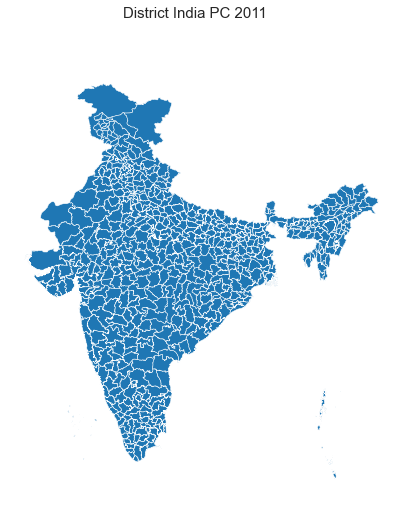

,censuscode,geometry
0,532,"POLYGON ((78.84972 19.76010, 78.85102 19.75945..."
1,146,"POLYGON ((78.19803 27.40280, 78.19804 27.40278..."
2,474,"MULTIPOLYGON (((72.03456 23.50527, 72.03337 23..."
3,522,"POLYGON ((74.67333 19.94670, 74.67393 19.93509..."
4,283,"POLYGON ((92.98749 24.40453, 92.99107 24.40236..."


In [11]:
# Loding the shape file
geo_map = gpd.read_file('data/ShapeFiles/2011_Dist.shp')

# Droping columns
geo_map = geo_map.drop([ 'DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD'], axis=1 )

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(8, 8))
# Add a layer with polygons on to axis `ax`
geo_map.plot(linewidth=0.5, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Title
f.suptitle('District India PC 2011', size=15)
# Display
plt.show()

# Display top of table
geo_map.head()

### Joining the data
- Joing the shape file and the health infrastructure data
- Renaming the 'censuscode' column

In [12]:
#Joining data 
social_economic = geo_map.join(nfhs_df, on = 'censuscode')

# renameing columns
social_economic = social_economic.rename(columns = {'censuscode' : 'pc11_district_id'})

# dropping all rows with missing data
social_economic = social_economic.dropna(axis=0)

# Display top of table
social_economic.head()

,pc11_district_id,geometry,pc11_state_id,no_water_dwelling,water_fetch_women,no_hand_wash_water,no_hand_wash_soap,no_toilet,firewood,mem_per_room,dum_65p,ex_diab_broad_ind_fem,ex_htn_broad_ind_fem,bmigrt27_5_fem,csmoke_fem
0,532,"POLYGON ((78.84972 19.76010, 78.85102 19.75945...",28.0,94.057808,73.839844,19.699417,55.132229,60.972797,58.650978,3.269048,22.739254,6.248434,23.249308,7.856513,0.423377
1,146,"POLYGON ((78.19803 27.40280, 78.19804 27.40278...",9.0,78.326317,64.659729,4.353027,19.643539,43.153305,23.043776,3.722865,25.063381,5.002852,10.225907,11.125309,0.199065
2,474,"MULTIPOLYGON (((72.03456 23.50527, 72.03337 23...",24.0,93.729004,70.192413,3.124207,13.295746,5.079690,11.330096,3.080909,30.250095,5.577953,13.421350,19.004723,0.000000
3,522,"POLYGON ((74.67333 19.94670, 74.67393 19.93509...",27.0,91.152519,82.289230,21.982292,34.097069,36.771778,34.828003,3.403307,41.986248,4.337093,13.353710,10.079562,0.329646
4,283,"POLYGON ((92.98749 24.40453, 92.99107 24.40236...",15.0,96.326996,62.201263,1.283852,2.135498,0.000000,11.294636,2.952653,28.001690,10.587908,22.679121,12.355630,12.097226


In [13]:
# General info
social_economic.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 640 entries, 0 to 640
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   pc11_district_id       640 non-null    int64   
 1   geometry               640 non-null    geometry
 2   pc11_state_id          640 non-null    float64 
 3   no_water_dwelling      640 non-null    float32 
 4   water_fetch_women      640 non-null    float32 
 5   no_hand_wash_water     640 non-null    float32 
 6   no_hand_wash_soap      640 non-null    float32 
 7   no_toilet              640 non-null    float32 
 8   firewood               640 non-null    float32 
 9   mem_per_room           640 non-null    float32 
 10  dum_65p                640 non-null    float32 
 11  ex_diab_broad_ind_fem  640 non-null    float32 
 12  ex_htn_broad_ind_fem   640 non-null    float32 
 13  bmigrt27_5_fem         640 non-null    float32 
 14  csmoke_fem             640 non-nul

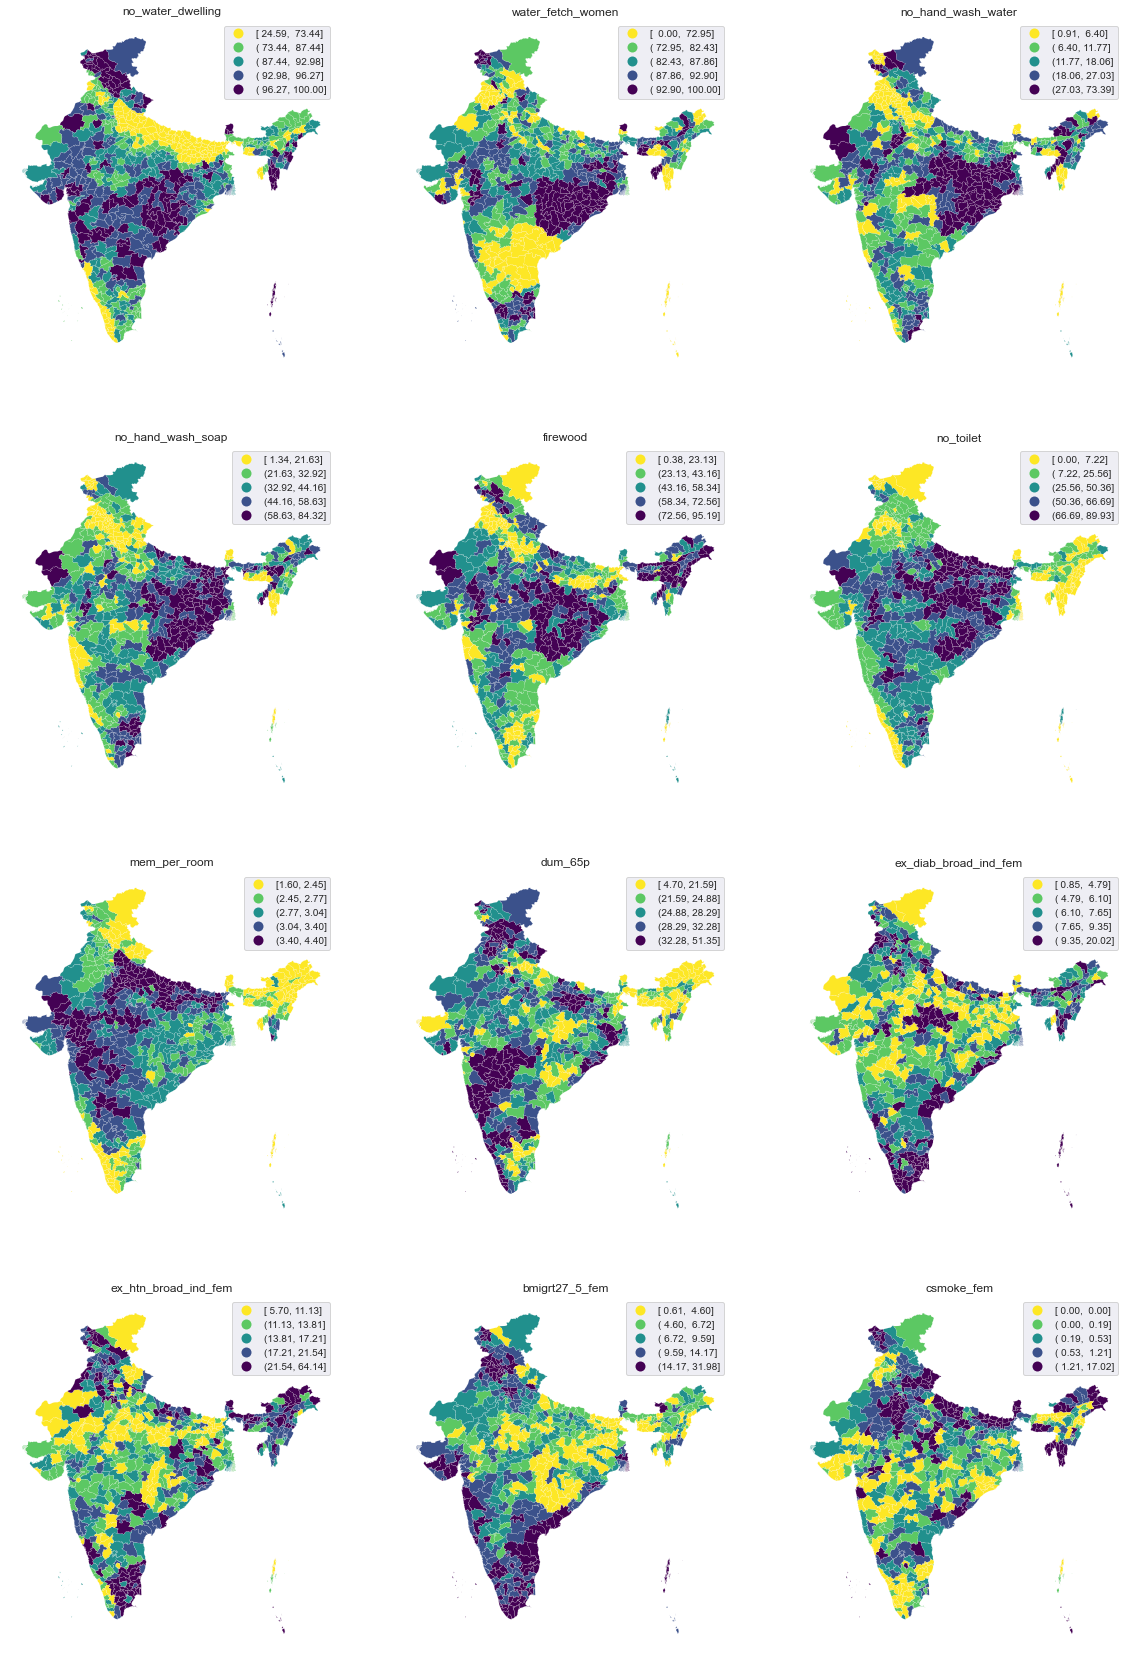

In [14]:
# Create figure and axes (this time it's 15, arranged 5 by 3)
f, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 30))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(indicators):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    social_economic.plot(column=col, ax=ax, scheme='Quantiles',edgecolor='w', \
             linewidth=0.1, cmap='viridis_r', alpha=1, legend=True)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

***To classify the areas by health care access, K-means clustering algorithm will be used. Because on this stage we are not sure about the importance of the sub-centers to efficiency of the system two clustering algorithms will be made one with (all_indicators) the sub-centers and one without(main_indicators)***

### Clustering


In [87]:
# setting number of clusters
kmeans5 = cluster.KMeans(n_clusters=5)
kmeans5

KMeans(n_clusters=5)

***To run the algorithm the fit() method will be used***

In [95]:
# This line is required to obtain the same results always. 
#(Computers are not truly random. They only seem that way. If this is interesting for you, ask me in class ;) Or try with a different seed.
np.random.seed(2000)
# Run the clustering algorithm
k5cls = kmeans5.fit(social_economic[infection])

In [96]:
k5cls.labels_

array([3, 0, 2, 0, 2, 2, 0, 2, 0, 1, 3, 2, 0, 2, 3, 0, 0, 2, 0, 3, 2, 0,
       1, 1, 1, 1, 3, 3, 1, 0, 3, 2, 3, 0, 2, 1, 4, 3, 1, 3, 3, 3, 3, 3,
       2, 2, 2, 1, 1, 3, 3, 1, 2, 3, 0, 2, 1, 2, 4, 1, 1, 3, 2, 1, 1, 3,
       3, 3, 1, 1, 2, 3, 0, 0, 3, 3, 2, 1, 2, 3, 3, 1, 3, 2, 0, 3, 4, 1,
       4, 3, 4, 3, 0, 3, 3, 0, 3, 4, 2, 4, 2, 0, 2, 3, 3, 4, 2, 0, 4, 1,
       2, 1, 3, 0, 0, 0, 3, 1, 3, 3, 2, 4, 0, 1, 0, 3, 0, 1, 0, 2, 2, 3,
       1, 2, 4, 3, 0, 1, 2, 1, 3, 0, 4, 0, 3, 3, 1, 0, 3, 4, 1, 4, 3, 4,
       4, 3, 1, 0, 0, 1, 1, 3, 0, 2, 2, 2, 2, 0, 0, 2, 3, 4, 2, 0, 3, 3,
       3, 2, 2, 3, 2, 2, 3, 3, 2, 3, 1, 2, 0, 2, 1, 3, 1, 0, 2, 1, 2, 3,
       1, 4, 1, 4, 3, 0, 1, 3, 3, 1, 3, 0, 2, 2, 0, 4, 2, 0, 4, 4, 0, 3,
       2, 0, 3, 0, 1, 3, 2, 0, 2, 4, 2, 2, 4, 2, 2, 0, 3, 2, 0, 1, 1, 2,
       0, 0, 3, 3, 0, 2, 0, 1, 1, 1, 1, 3, 1, 2, 3, 0, 3, 2, 0, 4, 4, 0,
       0, 1, 2, 1, 4, 2, 4, 1, 2, 3, 3, 4, 2, 3, 2, 3, 2, 4, 4, 4, 0, 2,
       3, 4, 3, 1, 1, 3, 1, 1, 1, 0, 0, 3, 0, 1, 2,

***Each number is different category***

In [99]:
social_economic['k5cls'] = k5cls.labels_

***Evaluation of the number of the clusters will be made by using the Elbow Method - the elbow method serves to determine the optimal number of clusters.***

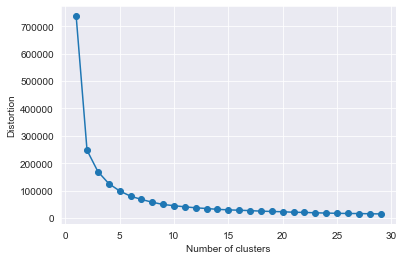

In [77]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 30):
    kmeans=KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    ) 
    kmeans.fit(social_economic[infection])
    distortions.append(kmeans.inertia_)

# plot
plt.plot(range(1, 30), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


***4 is the number where the line stop descending***

### Mapping the categories

At this point it is helpful to see the geographical distribution of the categories.


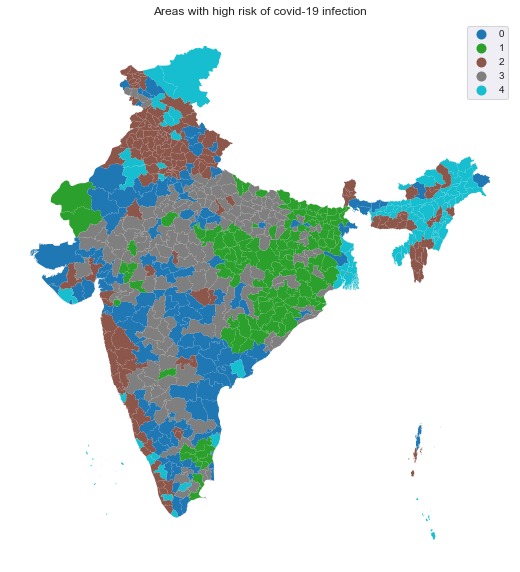

In [100]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot unique values choropleth including a legend and with no boundary lines
social_economic.plot(column='k5cls', categorical=True, cmap='tab10', legend=True ,linewidth=0, ax=ax)

# Remove axis
ax.set_axis_off()
# Add title
plt.title('Areas with high risk of covid-19 infection')

# Display the map
plt.show()

- 0 - dark blue - medium risk 
- 1 - green - highest risk 
- 2 - brown - lowest risk
- 3 - grey - second highest risk
- 4 - light blue - medium risk

### Exploring the nature of the categories

Some statisticasl exploraation will be reqaired as well 
- Count
- Mean
- Discribe 
- Distribution

In [101]:
k5sizes = social_economic.groupby('k5cls').size()
k5sizes

k5cls
0    119
1    123
2    162
3    153
4     83
dtype: int64

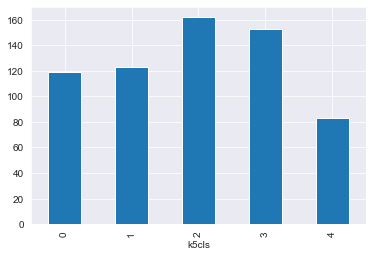

In [102]:
_ = k5sizes.plot.bar()

In [103]:
# Calculate the mean by group
k5means = social_economic.groupby('k5cls')[infection].mean()
# Show the table transposed (so it's not too wide)
k5means.T

k5cls,0,1,2,3,4
no_hand_wash_soap,35.221489,67.729721,16.461704,42.959396,44.318741
no_toilet,35.661488,72.689415,8.389722,61.687519,8.626062
mem_per_room,2.995458,3.093956,2.645199,3.330490,2.323135


In [104]:
# Name (index) the rows after the category they belong
to_plot = social_economic.set_index('k5cls')
# Subset to keep only variables used in K-means clustering
to_plot = to_plot[infection]
# Display top of the table
to_plot.head()

,no_hand_wash_soap,no_toilet,mem_per_room
k5cls,,,
3,55.132229,60.972797,3.269048
0,19.643539,43.153305,3.722865
2,13.295746,5.079690,3.080909
0,34.097069,36.771778,3.403307
2,2.135498,0.000000,2.952653


In [107]:
# setting number of clusters
kmeans5 = cluster.KMeans(n_clusters=5)
kmeans5

KMeans(n_clusters=5)

***To run the algorithm the fit() method will be used***

In [109]:
# This line is required to obtain the same results always. 
#(Computers are not truly random. They only seem that way. If this is interesting for you, ask me in class ;) Or try with a different seed.
np.random.seed(2000)
# Run the clustering algorithm
k5cls = kmeans5.fit(social_economic[death])

In [111]:
k5cls.labels_

array([4, 3, 3, 3, 4, 0, 3, 3, 0, 0, 0, 0, 0, 4, 0, 3, 3, 3, 4, 3, 1, 2,
       0, 0, 0, 4, 0, 0, 0, 3, 4, 3, 0, 0, 1, 4, 4, 0, 0, 4, 4, 4, 0, 0,
       1, 1, 3, 0, 0, 0, 4, 4, 4, 0, 0, 3, 0, 2, 4, 0, 0, 4, 3, 0, 0, 4,
       0, 0, 4, 0, 0, 0, 3, 3, 0, 0, 2, 0, 3, 0, 4, 0, 0, 4, 0, 0, 1, 0,
       3, 4, 4, 0, 4, 0, 0, 0, 0, 4, 3, 3, 0, 4, 4, 4, 0, 4, 1, 0, 4, 0,
       1, 0, 0, 3, 3, 4, 0, 0, 0, 3, 3, 0, 2, 1, 3, 1, 0, 0, 0, 3, 3, 0,
       0, 3, 0, 0, 3, 4, 3, 0, 4, 4, 0, 0, 0, 0, 4, 1, 0, 4, 4, 4, 0, 4,
       4, 2, 0, 3, 4, 0, 4, 0, 3, 4, 1, 1, 4, 1, 4, 4, 0, 2, 3, 1, 0, 0,
       4, 2, 3, 4, 4, 1, 0, 0, 1, 0, 0, 1, 3, 4, 3, 0, 4, 0, 3, 0, 3, 4,
       0, 4, 0, 4, 4, 4, 3, 4, 0, 0, 0, 1, 1, 2, 0, 4, 1, 0, 0, 3, 3, 4,
       3, 1, 3, 0, 0, 0, 4, 0, 1, 3, 1, 3, 3, 1, 3, 3, 4, 4, 0, 0, 4, 3,
       0, 3, 0, 0, 4, 1, 3, 0, 0, 0, 0, 0, 4, 3, 0, 0, 4, 0, 0, 4, 3, 4,
       3, 0, 3, 4, 4, 3, 1, 0, 3, 0, 0, 1, 3, 0, 4, 0, 1, 4, 0, 4, 1, 4,
       2, 3, 3, 0, 3, 0, 4, 4, 0, 3, 3, 0, 1, 4, 3,

***Each number is different category***

In [112]:
social_economic['k5cls'] = k5cls.labels_

***Evaluation of the number of the clusters will be made by using the Elbow Method - the elbow method serves to determine the optimal number of clusters.***

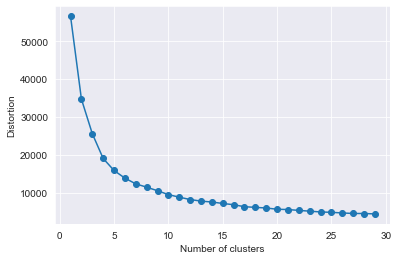

In [113]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 30):
    kmeans=KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    ) 
    kmeans.fit(social_economic[death])
    distortions.append(kmeans.inertia_)

# plot
plt.plot(range(1, 30), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


### Mapping the categories

At this point it is helpful to see the geographical distribution of the categories.


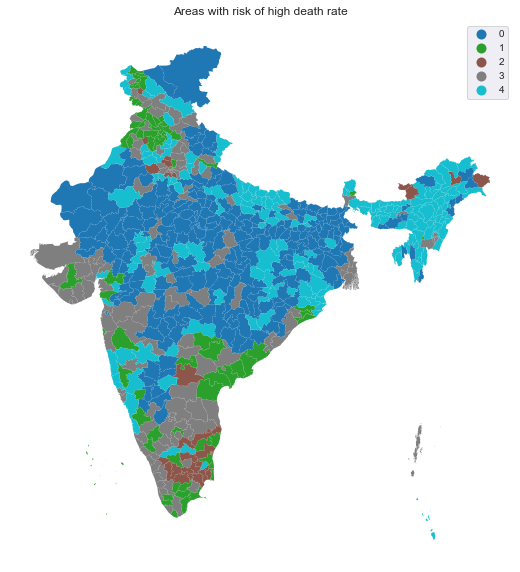

In [116]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot unique values choropleth including a legend and with no boundary lines
social_economic.plot(column='k5cls', categorical=True, cmap='tab10', legend=True ,linewidth=0, ax=ax)

# Remove axis
ax.set_axis_off()
# Add title
plt.title('Areas with risk of high death rate')

# Display the map
plt.show()

- 0 - dark blue - lowest risk 
- 1 - green - high risk 
- 2 - brown - high risk
- 3 - grey - medium risk
- 4 - light blue - medium risk

### Exploring the nature of the categories

Some statisticasl exploraation will be reqaired as well 
- Count
- Mean
- Discribe 
- Distribution

In [118]:
k5sizes = social_economic.groupby('k5cls').size()
k5sizes

k5cls
0    235
1     77
2     29
3    129
4    170
dtype: int64

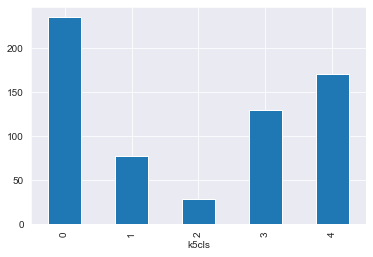

In [119]:
_ = k5sizes.plot.bar()

In [120]:
# Calculate the mean by group
k5means = social_economic.groupby('k5cls')[death].mean()
# Show the table transposed (so it's not too wide)
k5means.T

k5cls,0,1,2,3,4
ex_diab_broad_ind_fem,5.581252,9.415887,8.915735,8.081005,7.588722
ex_htn_broad_ind_fem,11.526774,21.417101,37.273964,13.611323,20.629505
bmigrt27_5_fem,5.208748,19.290161,14.066307,13.481965,7.135369


In [34]:
# Name (index) the rows after the category they belong
to_plot = social_economic.set_index('k_cls_high')
# Subset to keep only variables used in K-means clustering
to_plot = to_plot[high_risk_indicators]
# Display top of the table
to_plot.head()

NameError: name 'high_risk_indicators' is not defined